# Pytransformsorch session 2 - testing GPU

## Outline
1. Introduction to `torch.nn`, `torch.nn.Module`
2. Building a simple network using `torch.linear`
3. Basic use of `torch.optim`
3. Building a simple CNN


In this session we will walk through the steps for creating artificial neural networks and Convolutional Neural Networks (ANNs and CNNs) using tools built-in to PyTorch. This largely follows [PyTorch's ``nn.Module`` tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) as well as this [pytorch mnist tutorial on kaggle](https://nextjournal.com/gkoehler/pytorch-mnist). 

The dataset we use is the **MNIST** hand-written digits dataset. This consists of black-and-white images of hand-drawn digits between 0 and 9. It is often referred to as the "hello world" of machine learning. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torchvision
from torch import nn
import os
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, ToTensor
from PIL import Image
from torchvision import transforms
import requests



# Dataset

## set dir

In [18]:
root_dir = 'CBSD68'

# test - convert originaol to noise

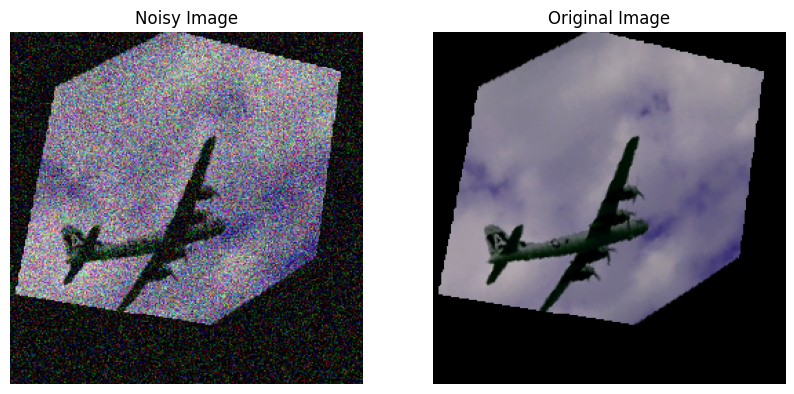

In [19]:
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms 
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

class AdjustedDenoisingDataset(Dataset):
    def __init__(self, root_dir, noise_std, transform=None, training=True):
        self.root_dir = root_dir
        self.transform = transform
        self.training = training
        self.noise_std = noise_std  # Now we pass the noise_std when initializing the dataset
        self.image_ids = [f"{i:04d}.png" for i in (range(56) if training else range(56, 68))]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        original_img_path = os.path.join(self.root_dir, 'original_png', image_id)  # Adjusted to use self.root_dir
        original_image = Image.open(original_img_path).convert("RGB")
        
        if self.transform:
            original_image = self.transform(original_image)
        
        original_image_np = np.array(original_image)
        standard_deviation = random.uniform(0, self.noise_std)

        noise = np.random.normal(0, standard_deviation, original_image_np.shape).astype(np.float32)
        noisy_image_np = original_image_np + noise
        noisy_image_np = np.clip(noisy_image_np, 0, 255).astype(np.uint8)
        
        noisy_image = Image.fromarray(noisy_image_np)
        
        noisy_image_tensor = transforms.ToTensor()(noisy_image)
        original_image_tensor = transforms.ToTensor()(original_image)
        
        return noisy_image_tensor, original_image_tensor

# Define transformations

transformations = transforms.Compose([
    transforms.RandomRotation((0, 360)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.Resize((256, 256))
])

# Example of how to instantiate the dataset for a specific noise level (e.g., 5)
noise_std = 50  # Standard deviation of the Gaussian noise
# Assuming adjusted_dataset is an instance of AdjustedDenoisingDataset with the transform applied
training_dataset = AdjustedDenoisingDataset(root_dir, noise_std=noise_std, transform=transformations, training=True)
test_dataset = AdjustedDenoisingDataset(root_dir, noise_std=noise_std, transform=transformations, training=False)

import matplotlib.pyplot as plt

# Assuming dataset is the instance of AdjustedDenoisingDataset
noisy_image, original_image = training_dataset[0]

# Convert the tensors to PIL images
noisy_image_pil = transforms.ToPILImage()(noisy_image)
original_image_pil = transforms.ToPILImage()(original_image)

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(noisy_image_pil)
axes[0].set_title('Noisy Image')
axes[0].axis('off')
axes[1].imshow(original_image_pil)
axes[1].set_title('Original Image')
axes[1].axis('off')

plt.show()



# Print the shapes of the noisy and original images
# print(f"Noisy image shape: {noisy_image.shape}")
# print(f"Original image shape: {original_image.shape}")

# MODEL

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#UNet model reference
"""
@misc{labml,
 author = {Varuna Jayasiri, Nipun Wijerathne},
 title = {labml.ai Annotated Paper Implementations},
 year = {2020},
 url = {https://nn.labml.ai/},
}
"""

'\n@misc{labml,\n author = {Varuna Jayasiri, Nipun Wijerathne},\n title = {labml.ai Annotated Paper Implementations},\n year = {2020},\n url = {https://nn.labml.ai/},\n}\n'

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the U-Net model
model = UNet(n_channels=3, n_classes=3).to(device)  # Adjust n_channels and n_classes if necessary

# loss funciton calcualtion SSIM

In [38]:
import torch
import torch.nn.functional as F

def gaussian_window(size, sigma):
    """
    Generates a 2D Gaussian Window.
    """
    coords = torch.arange(size, dtype=torch.float)
    coords -= size // 2

    g = coords**2
    g = (-g / (2 * sigma**2)).exp()

    g /= g.sum()
    return g.outer(g)

def ssim(img1, img2, window_size=11, window_sigma=1.5, size_average=True, channel=3):
    """
    Calculate the Structural Similarity Index (SSIM) between two color images.
    """
    L = 1  # Assuming images scaled [0, 1]
    C1 = (0.01 * L)**2
    C2 = (0.03 * L)**2
    
    window = gaussian_window(window_size, window_sigma).to(img1.device)
    window = window.expand(channel, 1, window_size, window_size)
    
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIMLoss(torch.nn.Module):
    def __init__(self, window_size=11, window_sigma=1.5, size_average=True, channel=3):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.window_sigma = window_sigma
        self.size_average = size_average
        self.channel = channel
        
    def forward(self, img1, img2):
        # 1 - SSIM because we want to minimize the distance (loss)
        return 1 - ssim(img1, img2, self.window_size, self.window_sigma, self.size_average, self.channel)


# TRAIN MODEL

training

In [41]:
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import pickle

batch_size = 60
n_epochs = 1
lr = 0.001

# Assuming AdjustedDenoisingDataset is correctly implemented and instantiated as 'dataset'
data_loader = DataLoader(training_dataset, batch_size, shuffle=True)

# Assuming the U-Net model is instantiated as 'model'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define an optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr)
criterion = SSIMLoss()

def train_model(model, data_loader, optimizer, criterion, n_epochs):
    losses = []
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch in data_loader:
            noisy_imgs, original_imgs = batch
            noisy_imgs, original_imgs = Variable(noisy_imgs.to(device)), Variable(original_imgs.to(device))
            
            optimizer.zero_grad()
            
            outputs = model(noisy_imgs)
            loss = criterion(outputs, original_imgs)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            losses.append(loss.item())
        
        epoch_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss}")
    print('Finished Training')
    return losses

losses = train_model(model, data_loader, optimizer, criterion, n_epochs)


save_data_dir = 'data'

# Create the directory if it doesn't exist
if not os.path.exists(save_data_dir):
    os.makedirs(save_data_dir)

# Specify the filename
pickle_file = 'data/losses'
pickle_file = pickle_file + str(len(os.listdir(save_data_dir))) + ".pkl"

# Pickle the losses variable
with open(pickle_file, 'wb') as f:
    pickle.dump(losses, f)

print(f"Losses pickled and saved to {pickle_file}")


Epoch 1/1, Loss: 0.41595399379730225
Finished Training
Losses pickled and saved to data/losses.pkl2


# save model

In [44]:
import os
# Specify the directory to save the file
save_dir = 'models'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Specify the filename
filename = 'trained_model'
filename = filename + str(len(os.listdir(save_dir))) + '.pth'

# Save the model state dictionary
print(torch.save(model.state_dict(), os.path.join(save_dir, filename)))


None


## Load Model

In [35]:
# Load model
import os

# List all the files in the '2_saved_models' folder
saved_models_folder = 'models'
matches = []
for root, dirnames, filenames in os.walk(saved_models_folder):
    for filename in filter(lambda name: name.endswith('.pth'), filenames):
        matches.append(os.path.join(root, filename))

# Display the available model files
print("Available model files:")
for i, file in enumerate(matches):
    print(f"{i+1}. {file}")

# Prompt the user to enter the index of the model file they want to load
selected_index = int(input("Enter the index of the model file to load: ")) - 1

# Load the selected model file
selected_model_file = matches[selected_index]
model = UNet(n_channels=3, n_classes=3)
model.load_state_dict(torch.load(selected_model_file))

Available model files:
1. models/trained_model0.pth


<All keys matched successfully>

# plot

Available data pkl files:
1: losses2.pkl
2: losses.pkl


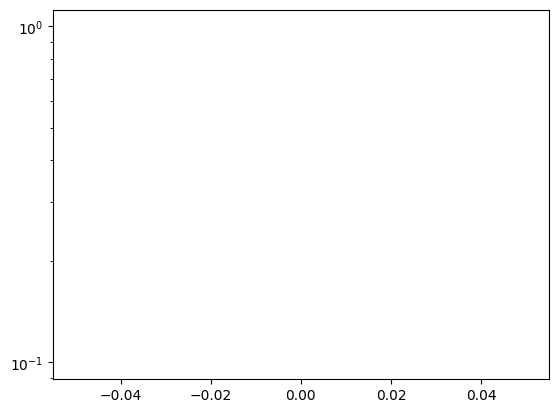

In [46]:
import pickle
import matplotlib.pyplot as plt
import os

data_folder = 'data'
files = os.listdir(data_folder)
pkl_files = [file for file in files if file.endswith('.pkl')]

print("Available data pkl files:")
for i, file in enumerate(pkl_files):
    print(f"{i + 1}: {file}")  # Adjusted index to match user input

# Assuming the user input part is handled outside of this script for this example
# For demonstration, let's say the user selected the first file
selected_pkl_index = int(input("Enter the index of the model file to load: ")) - 1
selected_model_file = pkl_files[selected_pkl_index]  # Fixed variable name

# Correct file path in the open function
with open(os.path.join(data_folder, selected_model_file), 'rb') as file:
    losses = pickle.load(file)

plt.plot(losses)
plt.yscale('log')
plt.show()  # Added to explicitly show the plot


## test data 
#### (compare loss function values)

In [22]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()  # Set the model to evaluation mode
criterion = nn.MSELoss()


test_losses = []
with torch.no_grad():
    for batch in test_loader:
        noisy_img, original_img = batch
        noisy_img, original_img = noisy_img.to(device), original_img.to(device)
        
        output = model(noisy_img)
        loss = criterion(output, original_img)
        test_losses.append(loss.item())

average_loss = sum(test_losses) / len(test_losses)
print(f"Average loss on test dataset: {average_loss}")


Average loss on test dataset: 0.0022327695041894913


## test image against model

In [36]:
import requests
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from io import BytesIO
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Additional function to convert tensor to PIL Image for visualization
def tensor_to_pil(tensor):
    unloader = transforms.ToPILImage()  # Convert tensor to PIL Image
    image = tensor.cpu().clone()  # Clone the tensor to not do changes on it
    image = image.squeeze(0)      # Remove the fake batch dimension
    image = unloader(image)
    return image

# Function to fetch image
def fetch_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB') 
    return img


def addnoise(image, noise_level):
    original_image_np = np.array(image)
    standard_deviation = random.uniform(0, noise_level)

    noise = np.random.normal(0, standard_deviation, original_image_np.shape).astype(np.float32)
    noisy_image_np = original_image_np + noise
    noisy_image_np = np.clip(noisy_image_np, 0, 255).astype(np.uint8)
    
    noisy_image = Image.fromarray(noisy_image_np)
    return noisy_image


# Function to denoise image using model
def denoise_image(image):
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        # Add any other preprocessing (e.g., normalization)
    ])

    input_tensor = preprocess(image).to(device).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor)
    return output.squeeze(0)  # Remove batch dimension


def process_image(image_url, noise_level):
    original_image = fetch_image(image_url)
    original_image = original_image.resize((256, 256))
    noisy_image = addnoise(original_image, noise_level)
    
    # Convert original_image to tensor for loss computation
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    original_image_tensor = preprocess(original_image).to(device)

    denoised_image_tensor = denoise_image(noisy_image)
    denoised_image = tensor_to_pil(denoised_image_tensor)

    # Compute loss
    loss = F.mse_loss(denoised_image_tensor, original_image_tensor)
    print(f"Loss value (MSE): {loss.item()}")

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_image)
    plt.title("Noisy Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image)
    plt.title("Denoised Image")
    plt.axis('off')

    plt.show()
    

image_url = input("Enter the URL of the image to denoise: \n")
noise_level = float(input("Enter the noise level (0-100): \n"))
process_image(image_url, noise_level)

ValueError: could not convert string to float: ''